# Overview

Here we present the simplified version of Arteri Radial detection using CNN [1] referring to Cokorda Gede Sedana Yoga's works. The objective is detecting the Arteri Radial from ultrasound images using Convolutional Neural Network (CNN). The architecture used is U-Net, since its capability in performing semantic segmentation to biomedical image.

[Arteri Radial Detection using CNN] (https://github.com/SedanaYoga/unetradar) 

# A. Image Preparation

The image preparation process consists of Image Extraction from Video (AVI) to image since the data acquired from USG devices, then Image Enhancement process to refine the quality of the image before entering the modeling (training) process.

In [2]:
import os
from os import listdir
import cv2
import numpy as np 
from natsort import natsorted, ns
import glob
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from scipy import ndimage, misc
from skimage import exposure
from scipy.ndimage import gaussian_filter

##  A.1. Image Extraction (from Video)

In [60]:
from IPython.display import clear_output
from filtering import *

cam = cv2.VideoCapture('dataset/Eka60.avi')
width = cam.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cam.get(cv2.CAP_PROP_FRAME_HEIGHT)
print('Dimensi : '+ str(int(width)) + ' x ' + str(int(height)))
fps = cam.get(cv2.CAP_PROP_FPS)
print('FPS : ' + str(int(fps)))
frame_count = cam.get(cv2.CAP_PROP_FRAME_COUNT)
print('Frame Count : ' + str(int(frame_count)))

outpath = 'dataset/ExtractedImage/'
try:
    # Pembuatan Folder (Kalau belum dibuat tidak bisa disimpan)
    if not os.path.exists(outpath):
        os.makedirs(outpath)
except OSError:
    print('Error: Creating directory of data')
# extract image
# Iterasi frame lengkap
currentframe = 0
# Iterasi sampling
samplingframe = 0
images = np.empty(int(frame_count)//10+1, dtype=object)
while(True):
     # Membaca dari frame
    ret, frame = cam.read()
            
    if ret:
        if (currentframe % 5 == 0):
            # Pembuatan gambar berkelanjutan
            name = outpath + str(samplingframe) + '.png'
                    
            croppedimg = frame[20:276,111:367]#frame[20:400,50:430]
                 
            # Membuat gambar dengan imwrite
            cv2.imwrite(name, croppedimg)
            samplingframe += 1
                    
        currentframe += 1
    else:
        break
cam.release()

Dimensi : 532 x 432
FPS : 30
Frame Count : 237


## A.2. Image Enhancement (example) 

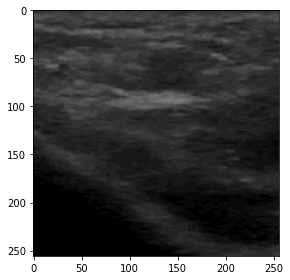

In [61]:
# open example image
img = io.imread('dataset/ExtractedImage/0.png')
io.imshow(img)
plt.show()

to Grayscale

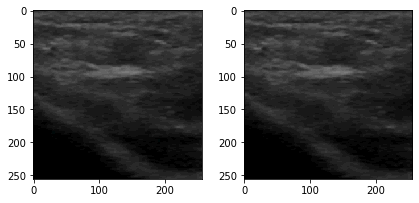

In [62]:
fig = plt.figure()
# before
ax0 = fig.add_subplot(121)
ax0 = io.imshow(img)

# after
ax1 = fig.add_subplot(122)
imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax1 = io.imshow(imggray)

Gaussian Filter

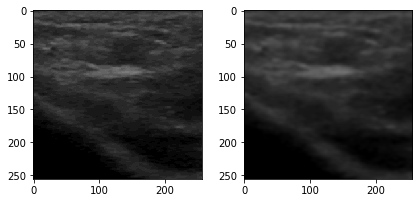

In [63]:
fig = plt.figure()
# before
ax0 = fig.add_subplot(121)
ax0 = io.imshow(imggray)

# after
ax1 = fig.add_subplot(122)
img_gaussian = gaussian_filter(imggray, sigma = 2)
ax1 = io.imshow(img_gaussian)

Intensity Rescaling

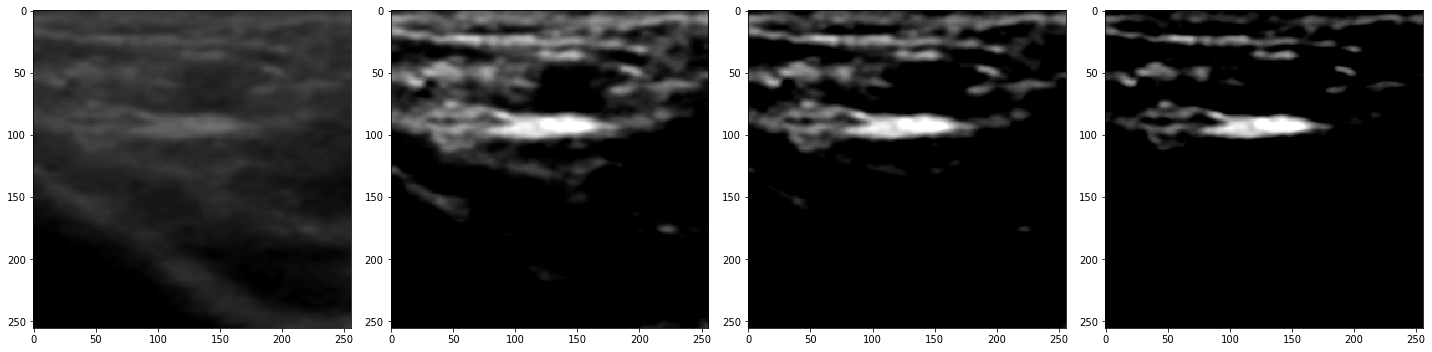

In [64]:
filter60 = (40,100)
filter80 = (50,100)
filter98 = (60,100)

fig = plt.figure(figsize=(20,10))
# before
ax0 = fig.add_subplot(141)
ax0 = io.imshow(img_gaussian)

# after 60
ax1 = fig.add_subplot(142)
rescale60 = exposure.rescale_intensity(img_gaussian, in_range=filter60)
ax1 = io.imshow(rescale60)
# after 80
ax2 = fig.add_subplot(143)
rescale80 = exposure.rescale_intensity(img_gaussian, in_range=filter80)
ax2 = io.imshow(rescale80)
# after 98
ax3 = fig.add_subplot(144)
rescale98 = exposure.rescale_intensity(img_gaussian, in_range=filter98)
ax3 = io.imshow(rescale98)

plt.show()

Histogram Equalization

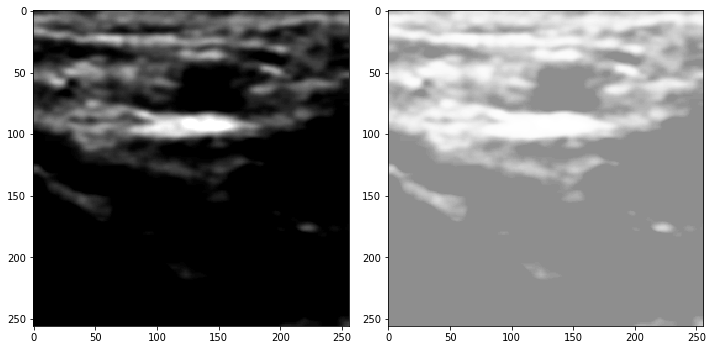

In [65]:
fig = plt.figure(figsize=(10,10))
# before
ax0 = fig.add_subplot(121)
ax0 = io.imshow(rescale60)

# after 1
ax1 = fig.add_subplot(122)
img_histeq = exposure.equalize_hist(rescale60)
ax1 = io.imshow(img_histeq)


Median Filter

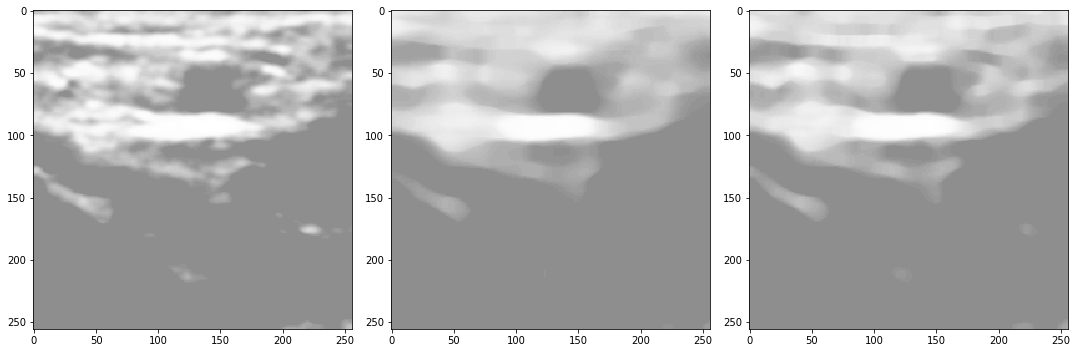

In [66]:
filter20 = 20
filter15 = 15

fig = plt.figure(figsize=(20,10))
# before
ax0 = fig.add_subplot(141)
ax0 = io.imshow(img_histeq)

# after 1
ax1 = fig.add_subplot(142)
img_median20 = ndimage.median_filter(img_histeq, size=filter20)
ax1 = io.imshow(img_median20)
# after 2
ax2 = fig.add_subplot(143)
img_median15 = ndimage.median_filter(img_histeq, size=filter15)
ax2 = io.imshow(img_median15)

plt.show()

Image Normalization

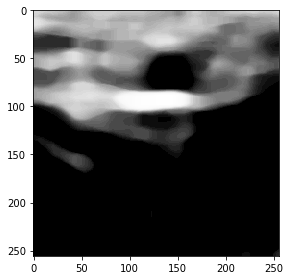

In [67]:
test_image = cv2.normalize(src=img_median20,
					dst=None,
					alpha=0, 
					beta=255,
					norm_type=cv2.NORM_MINMAX,
					dtype=cv2.CV_8U)
io.imshow(test_image)
plt.show()

# B. Modeling

[U-Net Standard] by S.-H. Tsang, “Review: U-Net (Biomedical Image Segmentation),” Towards Data Science, 5 November 2018. [Online]. Available: https://towardsdatascience.com/review-u-net-biomedical-image-segmentation-d02bf06ca760. [Accessed 13 November 2019].

In [4]:
from model import *

In [5]:
# pretrained version
model = unet(pretrained_weights='unet_weights100.hdf5')

# discomment below to train
"""
model_checkpoint = ModelCheckpoint('unet_weights100.hdf5', monitor='loss',verbose=1, save_best_only=True)
model = unet(pretrained_weights='unet_weights100.hdf5')"""

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

OSError: Unable to open file (unable to open file: name = 'unet_weights100.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Prediction

In [70]:
def prepare_image(img,shape=(256,256)):
    img = img/255
    img = trans.resize(img,shape)
    img = np.reshape(img, img.shape+(1,))
    img = np.reshape(img, (1,)+img.shape)
    return img
def get_image(img,cshape=(256,256),thr=None):
    #t = img[0].reshape(cshape[0],cshape[1],1)
    t = trans.resize(img[0],cshape)
    if thr:
        t[t[:,:,0] >= 0.1] = 1
        t[t[:,:,0] < 0.1] = 0
    return t

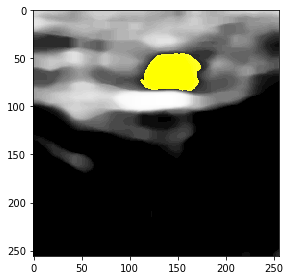

In [72]:
fig = plt.figure()

# Image Preparation
timage = prepare_image(test_image)
prediction = model.predict(timage) # main prediction
resimage = get_image(prediction) # in grayscale
# show image
temp = cv2.cvtColor(test_image, cv2.COLOR_GRAY2BGR)
temp[:,:,0][resimage[:,:,0] > 0.1] = 255
temp[:,:,1][resimage[:,:,0] > 0.1] = 255

io.imshow(temp)

The detected Arteri are given yellow-coloured.

# C. Evaluation

*Dice Similarity Matrix* 
$$\frac{|A \cap B|}{|A| + |B|}$$

In [57]:
def dsm(path):

    # Prediction
    img = io.imread('dataset/test/'+path)
    img = prepare_image(img)
    impred = model.predict(img)
    impred = get_image(impred,cshape=(432,532),thr=True)

    # Actual
    img = io.imread('dataset/Ground Truth/'+path)
    imact = prepare_image(img)
    imact = get_image(imact,cshape=(432,532))

    num = 2 * (impred.flatten() * imact.flatten()).sum()
    denum = impred.flatten().sum() + imact.flatten().sum()
    return num/denum

In [58]:
d = 0
for a in range(238):
    res = dsm(str(a)+'.png')
    print('DSM %d.png ==> %.2f'%(a,res))
    d += res
print('AVG : %.2f'%(d/238))

DSM 0.png ==> 0.89
DSM 1.png ==> 0.91
DSM 2.png ==> 0.89
DSM 3.png ==> 0.92
DSM 4.png ==> 0.90
DSM 5.png ==> 0.91
DSM 6.png ==> 0.93
DSM 7.png ==> 0.93
DSM 8.png ==> 0.92
DSM 9.png ==> 0.92
DSM 10.png ==> 0.94
DSM 11.png ==> 0.94


KeyboardInterrupt: 